# Xây dựng mô hình học máy và so sánh hiệu quả giữa chúng

In [ ]:
%cd /content/drive/MyDrive/DS-DM-Project

/content/drive/MyDrive/DS-DM-Project


In [ ]:
%pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00


## Import thư viện cần dùng

In [ ]:
# System library
import os
import time
import pickle
import warnings

# Statistics library
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Natural Language Toolkit
import nltk
import gensim
from pyvi import ViUtils, ViTokenizer

# Machine Learning
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier,
                              BaggingClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier)

from sklearn.metrics import accuracy_score, classification_report

# utils methods
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate
)

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn import (
    over_sampling as ios,
    under_sampling as ius,
    pipeline as ipl
)

In [ ]:
SEED = 42
RANDOM_STATE=123
warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 10)})
np.random.seed(SEED)

DATA_PATH = 'data/'
MODEL_PATH = 'model/'

## Phần I: Phân tích, tiền xử lý
Trong phần này, chúng ta sẽ tiến hành các bước để phân tích cơ bản về dữ liệu thu được và tiền xử lý chúng trước khi cho vào các mô hình học máy để tiến hành học

### Đọc các dữ liệu cần dùng

In [ ]:
# read dantri.json file
dantri = pd.read_json(os.path.join(DATA_PATH, 'dantri.json'))

# read vietnamese stopwords
with open(os.path.join(DATA_PATH, 'vietnamese-stopwords.txt'), 'r') as f:
  stopwords = [line.rstrip("\n").strip().replace(' ', '_') for line in f]

In [ ]:
# print first 5 object
dantri.head()

,title,category,content
0,"Thi hành án dứt điểm những vụ lớn, phức tạp li...",Xã hội,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c..."
1,"Món quà của Thủ tướng dành cho những người ""kh...",Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
2,Thủ tướng thị sát đường sắt Nhổn - ga Hà Nội: ...,Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
3,Đại sứ Saudi Arabia: Mong muốn Việt Nam sớm vư...,Xã hội,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...
4,"Tổng Thanh tra Chính phủ nói về giải pháp ""trị...",Xã hội,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...


In [ ]:
# remove `Nhân ái` class
dantri = dantri[dantri['category'] != 'Nhân ái']

In [ ]:
# print first 5 words in stopwords
stopwords[:5]

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy']

### Phân tích dữ liệu

In [ ]:
print(f"Dataset gồm {dantri.shape[0]} dữ liệu và {dantri.shape[1]} thuộc tính")

Dataset gồm 13331 dữ liệu và 3 thuộc tính


#### Remove NaN values

In [ ]:
dantri.isna().sum()

title       0
category    0
content     0
dtype: int64

Dữ liệu trên không có giá trị nào NaN cả nên chúng ta không cần phải loại bỏ chúng

In [ ]:
data = dantri[['content', 'category']]

Tổng có 15 hạng mục được thu về, tuy nhiên, có những bài báo rất ngắn vì nó chứa video, vì vậy chúng ta có thể chọn ra ngưỡng cho từng hạng mục để tránh việc bị Overfitting

#### Biểu đồ cột phân bố số lượng bài báo trên từng hạng mục

In [ ]:
count = data["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category": count.index, "count": count.values}
)
num_of_post_each_topic

,category,count
0,Thể thao,1497
1,Giáo dục,1414
2,Sức khỏe,1270
3,Bất động sản,1229
4,Kinh doanh,1102
5,Văn hóa,1044
6,Xã hội,967
7,Xe ++,910
8,Sức mạnh số,800
9,Thế giới,759


In [ ]:
def create_bar_plot(df=None, title="Số lượng bài báo trên từng hạng mục", y_arrow=500):
  fig = px.histogram(
    df,
    x='category',
    y='count',
    color='category',
    title=title,
    color_discrete_sequence=px.colors.qualitative.Light24,
    opacity=0.75
  )
  fig.update_yaxes(showgrid=True)  # the y-axis is in dollars
  fig.update_layout(  # customize font and legend orientation & position
      font_family="Arial",
      legend=dict(
          title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
      ),
      yaxis_title="Số lượng bài báo",
      xaxis_title="Hạng mục",
  )


  fig.add_shape(  # add a horizontal "target" line
      type="line",
      line_color="#16FF32",
      line_width=3,
      opacity=1,
      line_dash="dot",
      x0=0,
      x1=1,
      xref="paper",
      y0=929,
      y1=929,
      yref="y",
  )

  fig.add_annotation(  # add a text callout with arrow
      text="Số lượng ít nhất", x="Pháp luật", y=y_arrow, arrowhead=1, showarrow=True
  )


  fig.show()

In [ ]:
create_bar_plot(df=num_of_post_each_topic)

Với biểu đồ cột ở trên, thấy rằng phân bố `số lượng bài báo` trên từng `hạng mục` là không đồng đều nhau. Điều này có nghĩa là khi chia ngẫu nhiên dữ liệu để xây dựng mô hình có thể xảy ra tình trạng **Imbalanced Data** vì số lượng bài báo của hạng mục đầu tiên trên trung bình mẫu (đường màu xanh) đã gấp hơn 2 lần so với số lượng bài báo thấp nhất (đường mũi tên).

Từ những nhận xét sơ cấp ở trên, chúng ta có thể xem xét đến hiệu suất của mô hình khi đã qua xử lý việc mất cân bằng dữ liệu

In [ ]:
categories = data['category'].unique()
categories

array(['Xã hội', 'Việc làm', 'An sinh', 'Văn hóa', 'Thế giới',
       'Kinh doanh', 'Bất động sản', 'Sức mạnh số', 'Thể thao',
       'Sức khỏe', 'Giải trí', 'Giáo dục', 'Xe ++', 'Pháp luật'],
      dtype=object)

In [ ]:
data['len'] = data['content'].str.len()
data.head()

,content,category,len
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,2825
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3688
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3759
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,5821
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,4660


In [ ]:
def truncate_data(df, category):
  df_category = df.query(f"`category` == '{category}'")
  describe = df_category['len'].describe()
  at_75th = int(describe['75%'])
  at_25th = int(describe['25%'])
  return df_category[(df_category['len'] <= (at_75th-at_25th) * 3)]


In [ ]:
data_dict = {}
for category in categories:
  data_dict[category] = truncate_data(data, category)

In [ ]:
data_dict['Xã hội']

,content,category,len
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,2825
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3688
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3759
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,5821
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,4660
...,...,...,...
967,"Liên quan đến vụ, gia đình một chủ tịch phường...",Xã hội,2324
968,Liên quan tới vụ ô tô nổi bồng bềnh giữa hồ Tâ...,Xã hội,1039
969,"Ngày 1/4, trên mạng xã hội xôn xao hình ảnh kè...",Xã hội,1059
970,"Tối 31/3, trao đổi với PV Dân trí, ông Phạm Đì...",Xã hội,789


In [ ]:
newdata = pd.DataFrame(columns=['content', 'category', 'len'])
newdata

,content,category,len


In [ ]:
for key, value in data_dict.items():
  newdata = newdata.append(value)

newdata.reset_index(drop=True, inplace=True)

In [ ]:
newdata.shape

(12232, 3)

In [ ]:
newdata.head()

,content,category,len
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,2825
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3688
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3759
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,5821
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,4660


In [ ]:
def create_hist_plot(categories: list[str], df, num_subplots=3):
  fig, ax = plt.subplots(1, num_subplots)
  for idx, category in enumerate(categories):
    df_category = df.query(f"`category` == '{category}'")
    sns.histplot(data=df_category, x="len", kde=True, ax=ax[idx])
    ax[idx].set_title(category)
  plt.show()



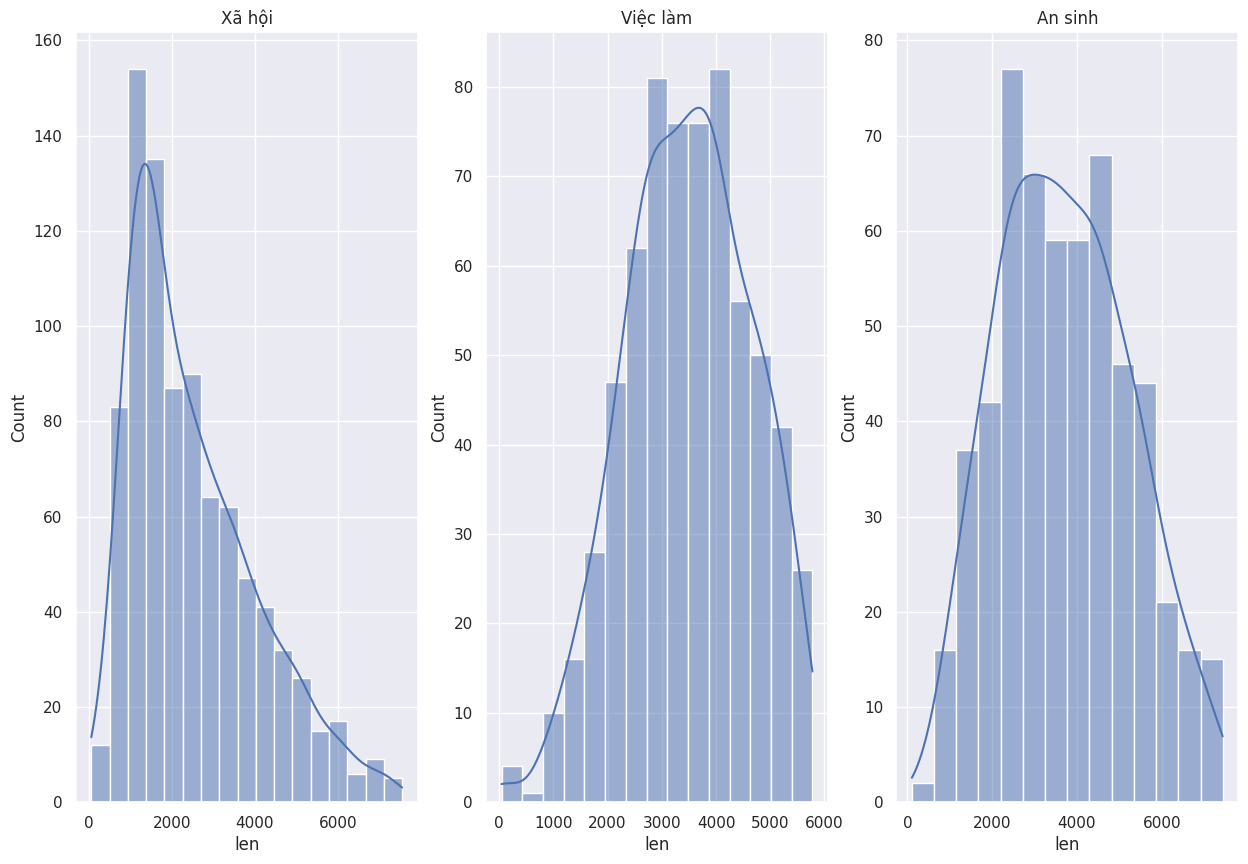

In [ ]:
create_hist_plot(categories[:3], df=newdata)

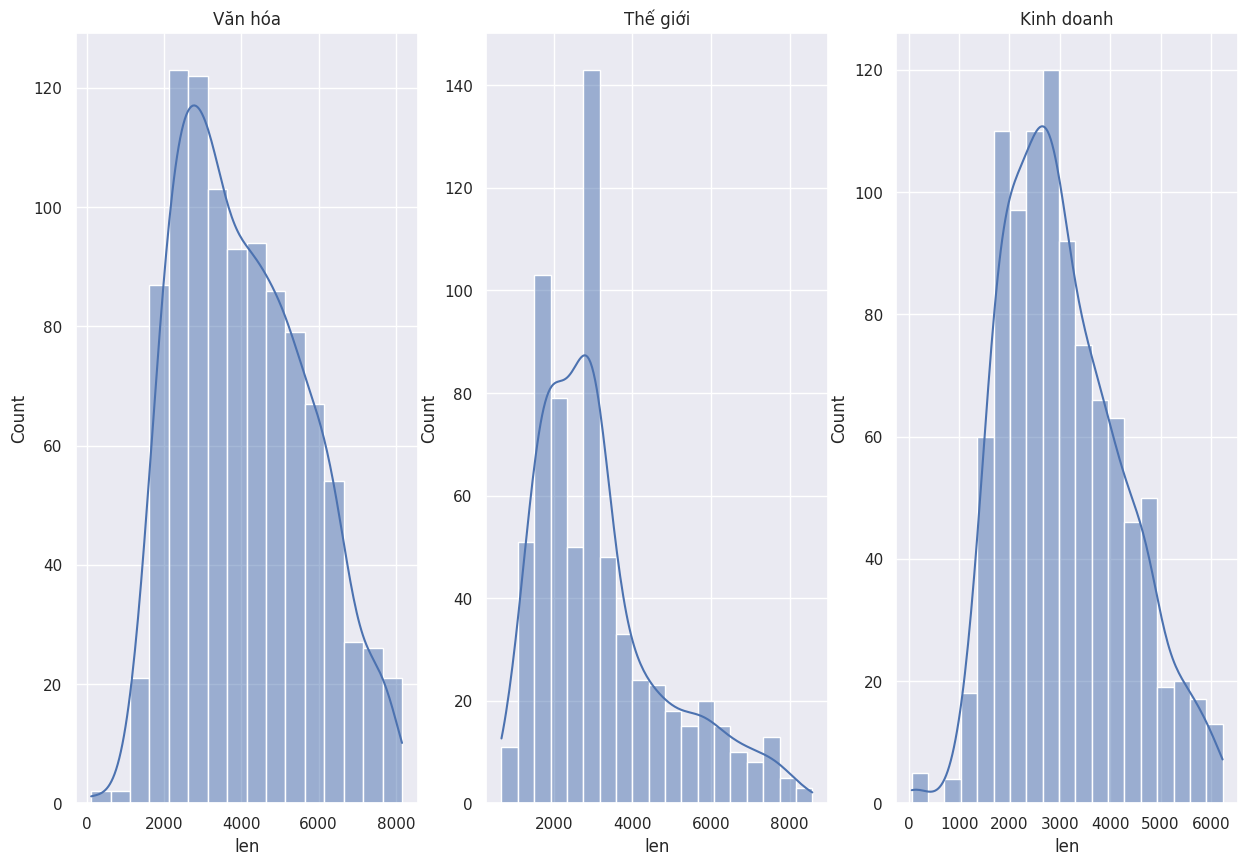

In [ ]:
create_hist_plot(categories[3:6], df=newdata)


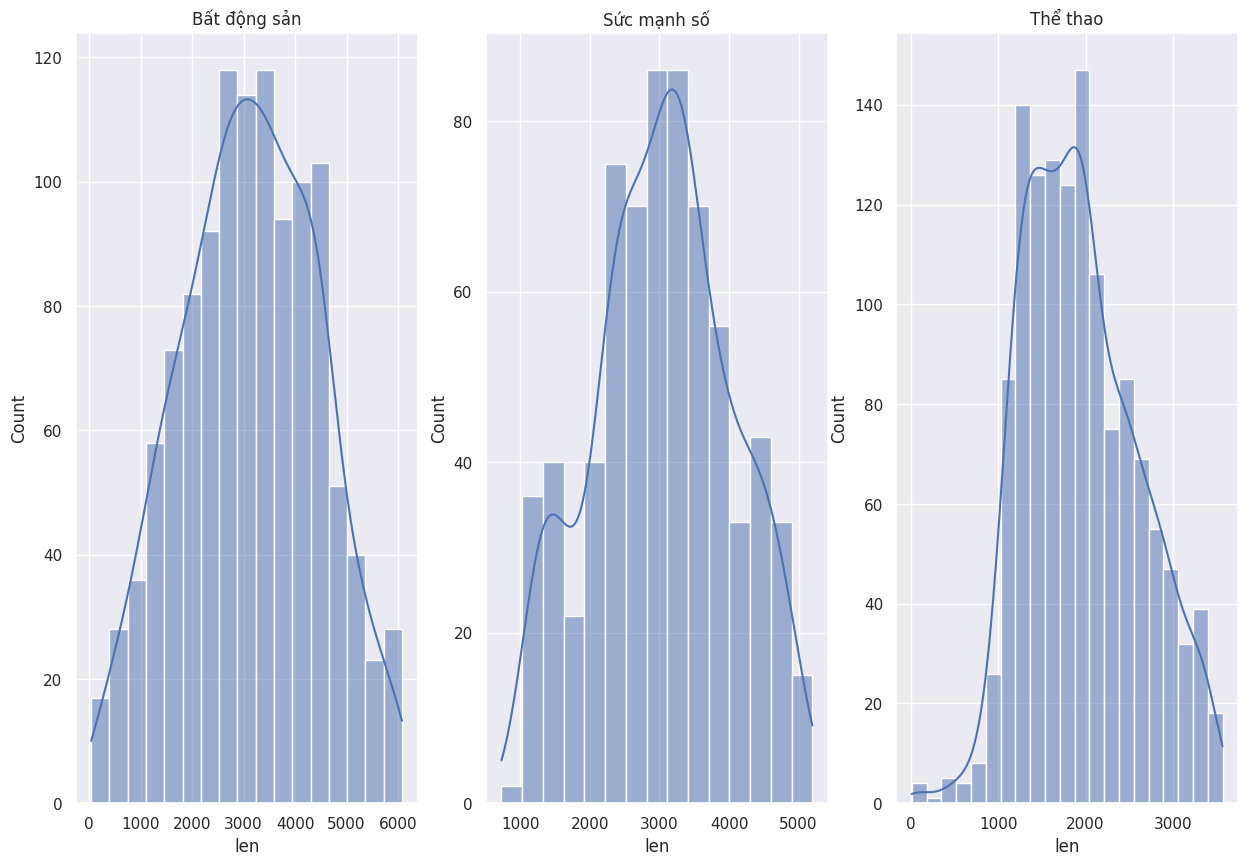

In [ ]:
create_hist_plot(categories[6:9], df=newdata)


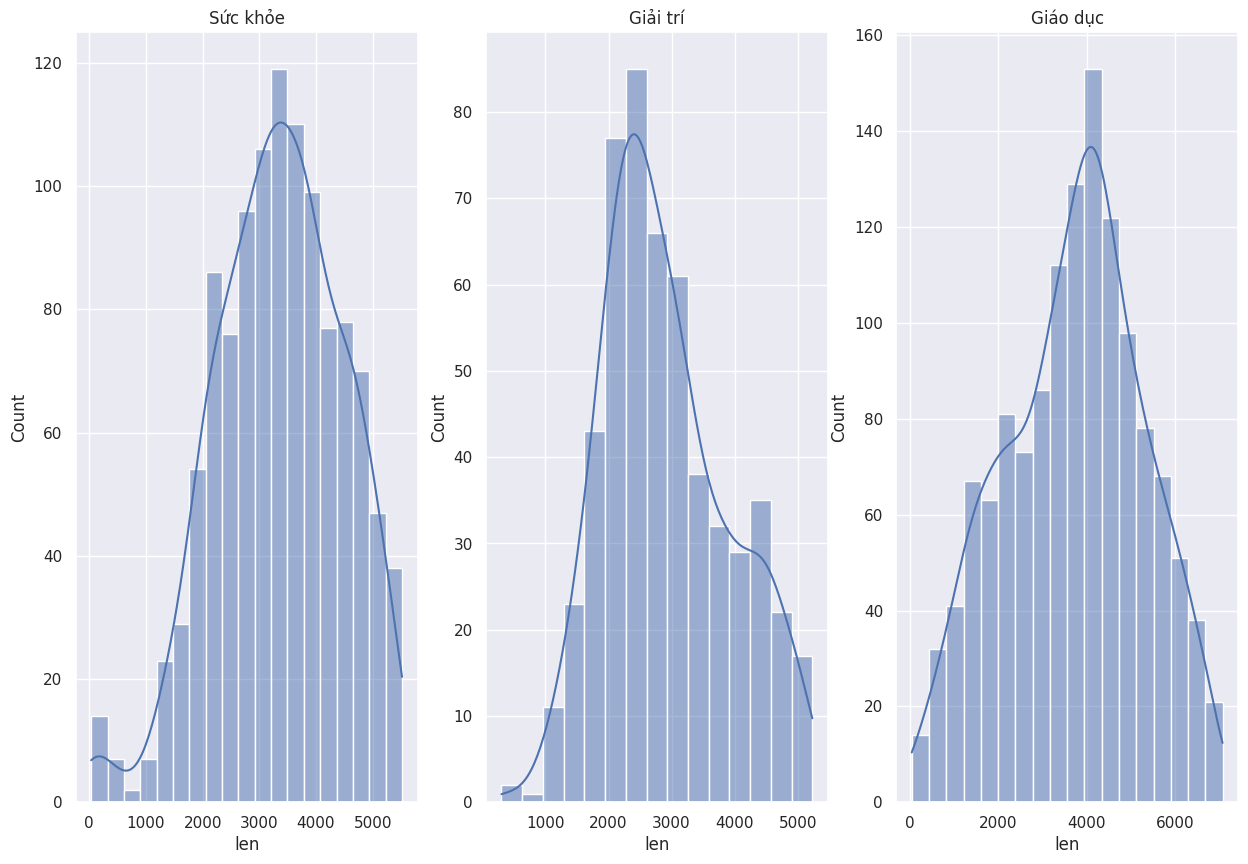

In [ ]:
create_hist_plot(categories[9:12], df=newdata)


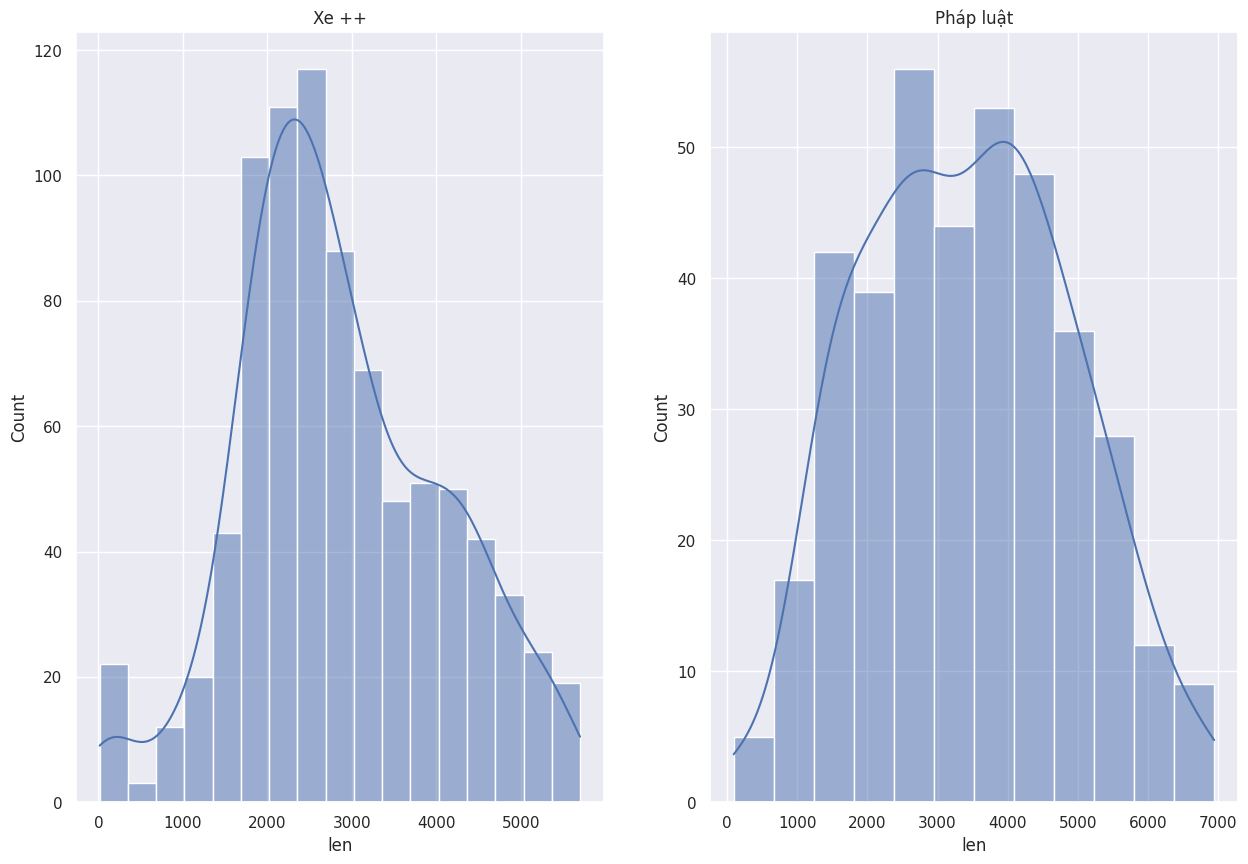

In [ ]:
create_hist_plot(categories[12:14], df=newdata, num_subplots=2)


Từ các biểu đồ phân phối trên, ta nhận thấy rằng, hầu hết các hạng mục đều tuân theo dạng hình chuông (phân phối Gaussian). Theo lý thuyết, thường phân phối chuẩn sẽ tốt cho mô hình khi học

In [ ]:
def create_boxplot(categories, df, title):
  df_categories = df[df['category'].isin(categories)]
  sns.boxplot(data=df_categories, x="category", y="len", hue='category')
  plt.title(title)
  plt.tight_layout()
  plt.xlabel("Category")
  plt.ylabel("len")
  plt.show()

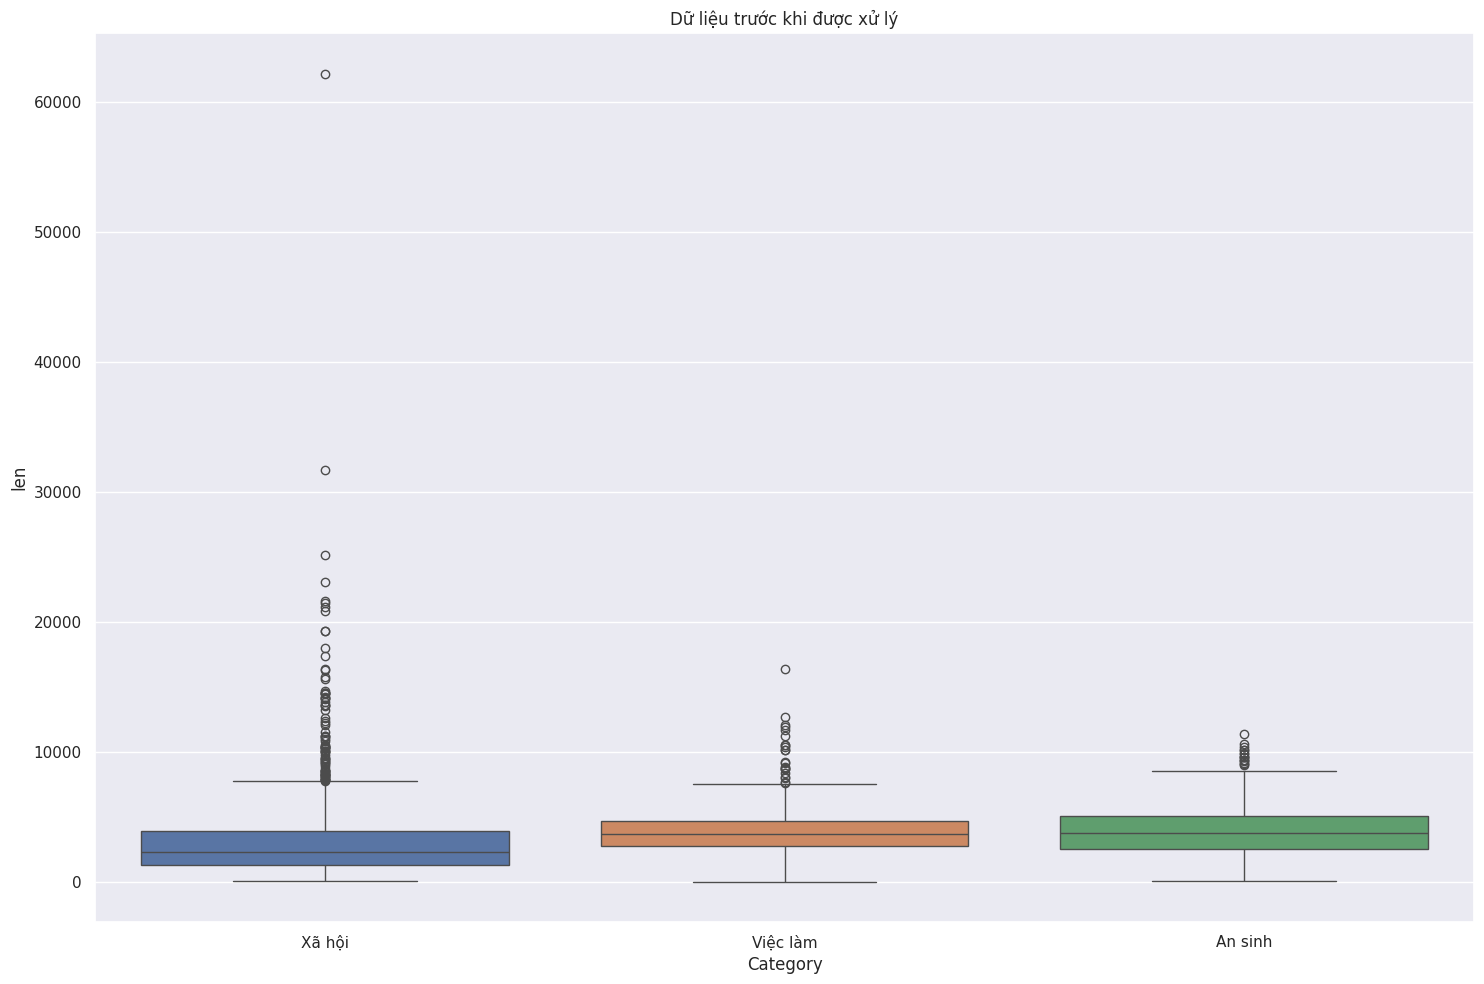

In [ ]:
create_boxplot(categories[0:3], data, title="Dữ liệu trước khi được xử lý")

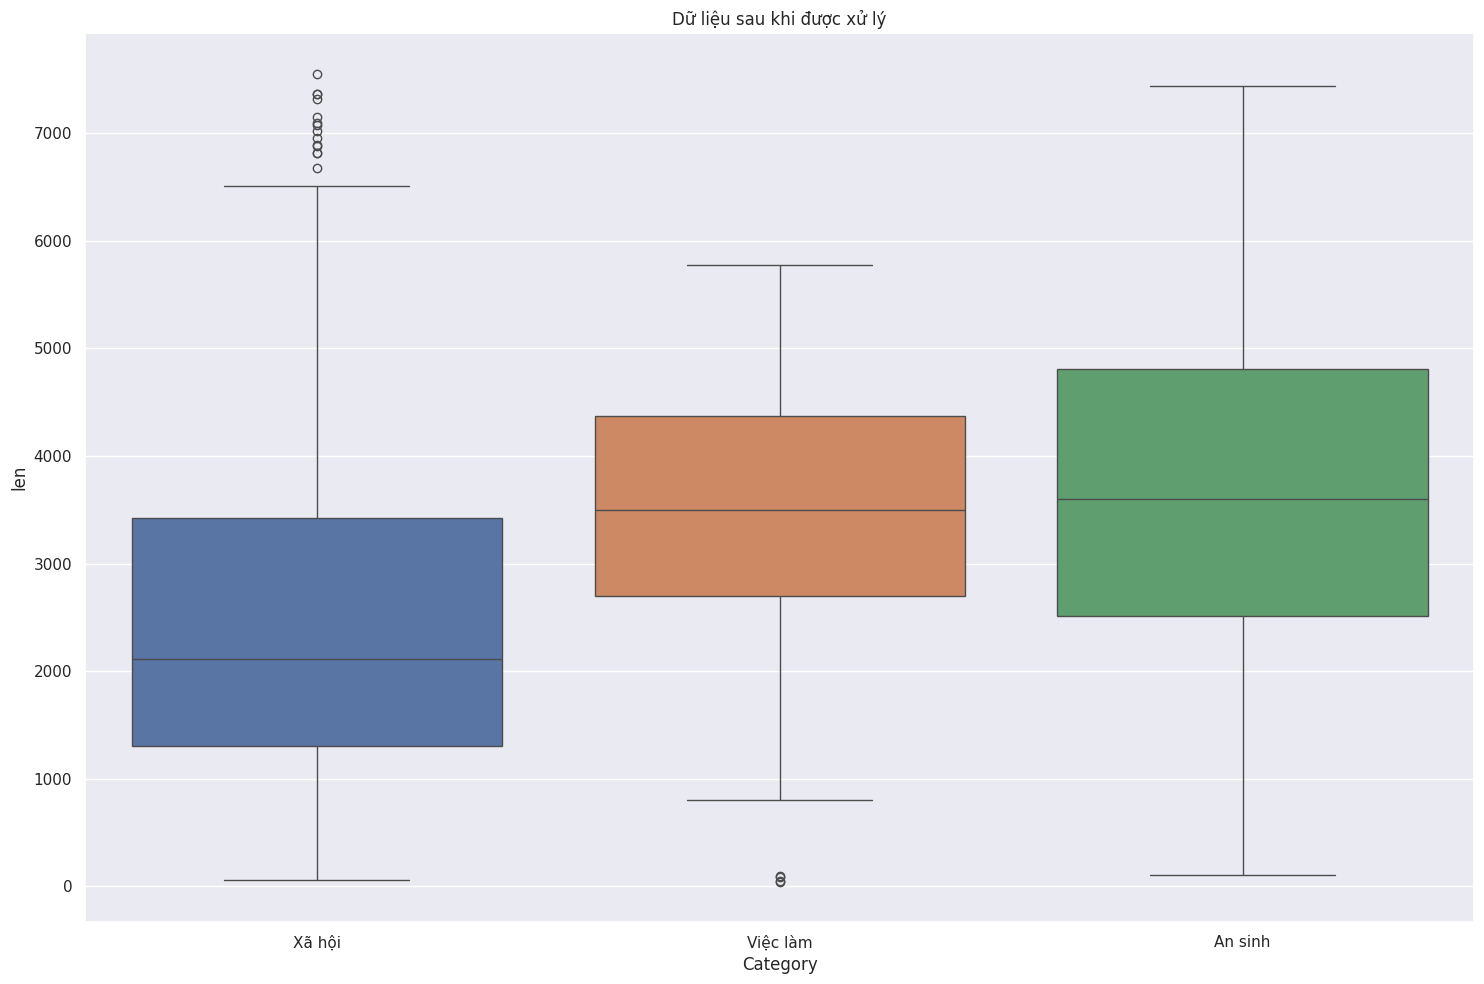

In [ ]:
create_boxplot(categories[0:3], newdata, title="Dữ liệu sau khi được xử lý")


In [ ]:
count = newdata["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category": count.index, "count": count.values}
)

create_bar_plot(df=num_of_post_each_topic)

### Data preprocessing
> Bình thường, trong tiếng Anh sẽ tách ra thành các từ đơn lẻ rồi chuyển sang dạng só thực một cách trực tiếp. Tuy nhiên, trong tiếng Việt sẽ có những từ phải đi cùng một cặp với nhau thì sẽ mang ý nghĩa rõ ràng hơn. Do đó cách xử lý sẽ khác so với tiếng Anh

In [ ]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_texts = []
        for text in X:
            cleaned_text = self.clean_text(text)
            cleaned_texts.append(cleaned_text)
        return np.array(cleaned_texts)

    @staticmethod
    def clean_text(content: str):
        # Text Normalizer
        # lowercase content
        # content = content.lower()
        # # remove white space
        # content = " ".join([x for x in content.split()])
        # # remove punctuation and digits
        # content = content.translate(str.maketrans("", "", punc_custom)).translate(
        #     str.maketrans("", "", digits)
        # )

        # Sử dụng `gensim` để xử lý cơ bản text
        tokens = gensim.utils.simple_preprocess(content)
        content = " ".join(tokens)
        # tokenize content
        content = ViTokenizer.tokenize(content)

        return content

In [ ]:
X, label = newdata['content'].values, newdata['category'].values

print(X.shape, label.shape)

(12232,) (12232,)


In [ ]:
print(X[:2])
print(label[:2])

['Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng cục Thi hành án dân sự (Bộ Tư pháp) vừa ký ban hành kế hoạch công tác năm 2024 của Tổ công tác chỉ đạo xử lý các vụ việc liên quan đến hoạt động tín dụng, ngân hàng (Tổ xử lý nợ xấu). Tổ xử lý nợ xấu có trách nhiệm phối hợp với Vụ Pháp chế (Ngân hàng Nhà nước), Hiệp hội Ngân hàng tổ chức tọa đàm, đối thoại giữa các cơ quan thi hành án với tổ chức tín dụng, Công ty quản lý tài sản (VAMC) để trao đổi, tháo gỡ khó khăn, vướng mắc liên quan đến các vụ việc thi hành án tín dụng, ngân hàng. Trong đó, tập trung rà soát, tổng hợp các vụ việc trên cơ sở thông báo kết luận kiểm tra các năm 2022, 2023 hoặc đề nghị của Hiệp hội Ngân hàng, các tổ chức tín dụng, VAMC. "Phối hợp chỉ đạo tổ chức thi hành dứt điểm đối với những vụ việc có điều kiện, nhất là những đơn vị có nhiều vụ việc lớn, phức tạp liên quan đến các tổ chức tín dụng như Agribank, Vietcombank, VPBank, BIDV, Vietinbank", lãnh đạo Tổng cục Thi hành án dân sự nêu rõ. Ông Nguyễn Văn Sơn, Phó 

In [ ]:
le = LabelEncoder()
y = le.fit_transform(label)

print(le.classes_)

['An sinh' 'Bất động sản' 'Giáo dục' 'Giải trí' 'Kinh doanh' 'Pháp luật'
 'Sức khỏe' 'Sức mạnh số' 'Thế giới' 'Thể thao' 'Việc làm' 'Văn hóa'
 'Xe ++' 'Xã hội']


#### Chia dữ liệu thành tập train và test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [ ]:
train_category = pd.DataFrame({'category': y_train})
train_category.head()

,category
0,5
1,1
2,13
3,2
4,1


In [ ]:
count = train_category["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category_le": count.index, "count": count.values}
)
num_of_post_each_topic['category'] = le.inverse_transform(num_of_post_each_topic['category_le'])
num_of_post_each_topic.head()

,category_le,count,category
0,9,937,Thể thao
1,2,922,Giáo dục
2,1,802,Bất động sản
3,6,780,Sức khỏe
4,4,698,Kinh doanh


In [ ]:
create_bar_plot(df=num_of_post_each_topic, y_arrow=450)

In [ ]:
num_of_post_each_topic['count'].describe()

count     14.000000
mean     611.571429
std      203.360882
min      286.000000
25%      466.000000
50%      618.000000
75%      759.500000
max      937.000000
Name: count, dtype: float64

In [ ]:
X_train.shape

(8562,)

#### Xây dựng tệp từ điển

Vì độ dài của các bài báo thường khá dài, từ các biểu đồ phân phối ở trên, chúng ta có thể thấy rằng, các bài báo thường từ 2000 từ trở lên, có nghĩa là nếu càng nhiều bài báo thì từ vựng càng nhiều, nếu mô tả một đoạn text theo tất cả các từ vựng đó thì ma trận sẽ rất lớn chưa kể đến việc nó là ma trận thưa (hầu hết là các giá trị 0)

In [ ]:
# No Cleaner
# count_vectorizer_no_cleaner = CountVectorizer(stop_words=stopwords)
# count_vectorizer_no_cleaner.fit(X_train)
# MAX_FEATURES = len(count_vectorizer_no_cleaner.vocabulary_)

# With Cleaner
# text_cleaner = TextCleaner()
# count_vectorizer_with_cleaner = CountVectorizer(stop_words=stopwords)
# X_train_with_cleaner = text_cleaner.fit_transform(X_train)
# count_vectorizer_with_cleaner.fit(X_train_with_cleaner)
# MAX_FEATURES_WITH_CLEANER = len(count_vectorizer_with_cleaner.vocabulary_)

In [ ]:
# MAX_FEATURES_WITH_CLEANER #, MAX_FEATURES

#### Tạo Pipeline cho việc tiền xử lý dữ liệu text

In [ ]:
# MAX_FEATURES_WITH_CLEANER = 30000
def create_pipeline(stop_words, cleaner=False, max_features=10000, reduction=False, n_components=5000):
  steps = []

  count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=max_features)
  if cleaner:
    text_cleaner = TextCleaner()
    steps.append(('cleaner', text_cleaner))

  # Add steps to convert text to matrix
  steps.append(('count_vectorizer', count_vectorizer))
  steps.append(('tfidf_transformer', TfidfTransformer()))

  if reduction:
    steps.append(('reduction', TruncatedSVD(n_components=n_components)))

  return Pipeline(steps)



#### Chuyển dữ liệu dạng text sang dạng ma trận
Chúng ta sẽ giữ lại khoảng 60% từ vựng, việc giảm số từ vựng xuống giúp cho mô hình giảm độ phức tạp, và chi phí tính toán được giảm thiểu

> Đối với các mô hình Machine Learning, nó có thể *linh hoạt* hơn khi đào tạo với ma trận có kích thước cỡ lớn. Tuy nhiên, vì chúng ta có mục tiêu sẽ `thử` ứng dụng các mô hình **Deep Learning** như CNN và LSTM để **so sánh** hiệu suất giữa **Machine Learning** và **Deep Learning** nên việc **giảm chiều dữ liệu** là vô cùng cần thiết, vì nếu chúng ta đưa quá nhiều Input vào mô hình Neural Networks thì mô hình sẽ có độ phức tạp cao và chi phí tính toán "đắt đỏ"

In [ ]:
MAX_FEATURES = 10000
N_COMPONENTS = 5000

pipeline = {}
# pipeline['only_cleaner'] = create_pipeline(stopwords, cleaner=True, max_features=MAX_FEATURES)
pipeline['cleaner_and_reduction'] = create_pipeline(stopwords, cleaner=True, max_features=MAX_FEATURES,
                                                    reduction=True, n_components=N_COMPONENTS)

In [ ]:
# transform train and test set
# X_train_cleaner_ = pipeline['only_cleaner'].fit_transform(X_train)
# X_test_cleaner_ = pipeline['only_cleaner'].transform(X_test)

X_train_cleaner_and_reduction_ = pipeline['cleaner_and_reduction'].fit_transform(X_train)
X_test_cleaner_and_reduction_ = pipeline['cleaner_and_reduction'].transform(X_test)

In [ ]:
# Save processed data
with open(os.path.join(MODEL_PATH, 'X_train_cleaner_and_reduction_.pkl'), 'wb') as f:
  pickle.dump(X_train_cleaner_and_reduction_, f)

with open(os.path.join(MODEL_PATH, 'X_test_cleaner_and_reduction_.pkl'), 'wb') as f:
  pickle.dump(X_test_cleaner_and_reduction_, f)

In [ ]:
# Load processed data
with open(os.path.join(MODEL_PATH, 'X_train_cleaner_and_reduction_.pkl'), 'rb') as f:
  X_train_cleaner_and_reduction_ = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'X_test_cleaner_and_reduction_.pkl'), 'rb') as f:
  X_test_cleaner_and_reduction_ = pickle.load(f)

> Sau khi xử lý, dữ liệu hiện giờ đã ở dạng số thực và chúng ta có thể sử dụng trực tiếp vào mô hình, tuy nhiên điều này vẫn là chưa lên vì theo lý thuyết, các mô hình học máy "**tốt**" khi các lớp đã "**cân bằng**". Vì vậy chúng ta cần xử lý việc này vào phần sau

In [ ]:
# print(X_train_cleaner_.shape)
print(X_train_cleaner_and_reduction_.shape)

(8562, 5000)


In [ ]:
X_train_cleaner_and_reduction_[0]

array([ 0.2663626 ,  0.03453088, -0.07849095, ..., -0.00737457,
       -0.00048187,  0.00237583])

#### Xử lý Imbalanced data

In [ ]:
sampling = {}
categories_geq_600 = num_of_post_each_topic[num_of_post_each_topic['count'] >= 600][['category_le', 'count']]
categories_le_600 = num_of_post_each_topic[num_of_post_each_topic['count'] < 600][['category_le', 'count']]
# num_of_post_each_topic['count'] >= 700
# categories_geq_700
sampling['under'] = {
    key: 600
    for (key, value) in categories_geq_600.values
  }
sampling['over'] = {key: 600 for (key, value) in categories_le_600.values}
sampling

{'under': {9: 600, 2: 600, 1: 600, 6: 600, 4: 600, 11: 600, 13: 600, 12: 600},
 'over': {7: 600, 8: 600, 10: 600, 0: 600, 3: 600, 5: 600}}

In [ ]:
# over = ios.BorderlineSMOTE(sampling_strategy=sampling['over'], n_jobs=-1)
# under = ius.RandomUnderSampler(sampling_strategy=sampling['under'])

# sampling_steps = [('over', over), ('under', under)]
# sampling_pipeline = ipl.Pipeline(sampling_steps)

# X_train_cleaner_sampled_, y_train_cleaner_sampled_ = sampling_pipeline.fit_resample(X_train_cleaner_, y_train)

In [ ]:
over = ios.BorderlineSMOTE(sampling_strategy=sampling['over'], n_jobs=-1, random_state=RANDOM_STATE)
under = ius.RandomUnderSampler(sampling_strategy=sampling['under'], random_state=RANDOM_STATE)

sampling_steps = [('over', over), ('under', under)]
sampling_pipeline = ipl.Pipeline(sampling_steps)

X_train_cleaner_and_reduction_sampled_, y_train_cleaner_and_reduction_sampled_ = sampling_pipeline.fit_resample(X_train_cleaner_and_reduction_, y_train)

In [ ]:
from collections import Counter
Counter(y_train_cleaner_and_reduction_sampled_)

Counter({0: 600,
         1: 600,
         2: 600,
         3: 600,
         4: 600,
         5: 600,
         6: 600,
         7: 600,
         8: 600,
         9: 600,
         10: 600,
         11: 600,
         12: 600,
         13: 600})

## Phần II: Xây dựng mô hình

Chúng ta sẽ sử dụng tối ưu tham số để tìm ra mô hình tốt nhất và sau đó sẽ so sánh chúng với nhau

In [ ]:
def evaluation_model(y_pred, y_test):
  acc = accuracy_score(y_test, y_pred)
  print("- Acc = {}".format(acc))
  print(classification_report(y_test, y_pred, target_names=le.classes_))
  return acc

### 2.1 Single Classifier

In [ ]:
def train_model(estimator, X_train, y_train, X_test, y_test):
  estimator_start = time.time()
  estimator.fit(X_train, y_train)
  print("Fit data completely ...")
  estimator_train_time = int(time.time() - estimator_start)
  y_pred = estimator.predict(X_test)

  estimator_acc = evaluation_model(y_pred, y_test)
  return estimator, estimator_acc, estimator_train_time


In [ ]:
skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
def create_params_based_on_estimator(estimator, X_train, y_train, scoring='accuracy', return_train_score=True, cv=None):
  params = dict (
      estimator=estimator,
      X=X_train,
      y=y_train,
      scoring=scoring,
      return_train_score=return_train_score,
      cv=cv,
      n_jobs=-1,
      verbose=3
  )
  return params

#### SVM

In [ ]:

cv_params_svm = create_params_based_on_estimator(SVC(C=1.0, kernel='linear', random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

svm_cv = cross_validate(
    **cv_params_svm
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.9min finished


In [ ]:
svm_clf, svm_acc, svm_time = train_model(cv_params_svm['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8948228882833787
              precision    recall  f1-score   support

     An sinh       0.73      0.71      0.72       172
Bất động sản       0.95      0.90      0.93       373
    Giáo dục       0.93      0.93      0.93       405
    Giải trí       0.81      0.81      0.81       152
  Kinh doanh       0.87      0.83      0.85       287
   Pháp luật       0.89      0.96      0.93       103
    Sức khỏe       0.97      0.98      0.98       358
 Sức mạnh số       0.93      0.91      0.92       218
    Thế giới       0.86      0.83      0.85       197
    Thể thao       0.98      0.98      0.98       388
    Việc làm       0.79      0.84      0.81       194
     Văn hóa       0.87      0.84      0.86       319
       Xe ++       0.94      0.98      0.96       240
      Xã hội       0.78      0.85      0.81       264

    accuracy                           0.89      3670
   macro avg       0.88      0.88      0.88      3670
weighted avg       0.90      

In [ ]:
# with open(os.path.join(MODEL_PATH, 'svm_clf.pkl'), 'wb') as f:
#   pickle.dump(svm_clf, f)

# with open(os.path.join(MODEL_PATH, 'svm_cv.pkl'), 'wb') as f:
#   pickle.dump(svm_cv, f)

In [ ]:
#Load results
with open(os.path.join(MODEL_PATH, 'svm_clf.pkl'), 'rb') as f:
  svm_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'svm_cv.pkl'), 'rb') as f:
  svm_cv = pickle.load(f)

In [ ]:
svm_cv

{'fit_time': array([205.85080695, 204.18498588, 201.55848169, 202.74157453,
        107.63038158]),
 'score_time': array([49.02532315, 47.40264821, 47.56283641, 48.06446743, 26.69914889]),
 'test_score': array([0.91607143, 0.90952381, 0.91488095, 0.92083333, 0.91904762]),
 'train_score': array([0.98110119, 0.98139881, 0.98005952, 0.98050595, 0.97931548])}

#### SGD

In [ ]:
cv_params_sgd = create_params_based_on_estimator(SGDClassifier(loss='modified_huber', max_iter=1000, eta0=0.001, early_stopping=True, n_jobs=-1, random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

sgd_cv = cross_validate(
    **cv_params_sgd
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished


In [ ]:
sgd_clf, sgd_acc, sgd_time = train_model(cv_params_sgd['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8809264305177111
              precision    recall  f1-score   support

     An sinh       0.73      0.65      0.69       172
Bất động sản       0.98      0.85      0.91       373
    Giáo dục       0.92      0.93      0.92       405
    Giải trí       0.71      0.86      0.78       152
  Kinh doanh       0.87      0.83      0.85       287
   Pháp luật       0.88      0.97      0.92       103
    Sức khỏe       0.95      0.98      0.97       358
 Sức mạnh số       0.94      0.91      0.92       218
    Thế giới       0.91      0.80      0.85       197
    Thể thao       0.98      0.98      0.98       388
    Việc làm       0.80      0.76      0.78       194
     Văn hóa       0.90      0.78      0.84       319
       Xe ++       0.94      0.97      0.95       240
      Xã hội       0.67      0.91      0.77       264

    accuracy                           0.88      3670
   macro avg       0.87      0.87      0.87      3670
weighted avg       0.89      

In [ ]:
with open(os.path.join(MODEL_PATH, 'sgd_clf.pkl'), 'wb') as f:
  pickle.dump(sgd_clf, f)

with open(os.path.join(MODEL_PATH, 'sgd_cv.pkl'), 'wb') as f:
  pickle.dump(sgd_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'sgd_clf.pkl'), 'rb') as f:
  sgd_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'sgd_cv.pkl'), 'rb') as f:
  sgd_cv = pickle.load(f)

#### GaussianNB

In [ ]:
cv_params_gnb = create_params_based_on_estimator(GaussianNB(),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

gnb_cv = cross_validate(
    **cv_params_gnb
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished


In [ ]:
gnb_clf, gnb_acc, gnb_time = train_model(cv_params_gnb['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.3138964577656676
              precision    recall  f1-score   support

     An sinh       0.08      0.74      0.14       172
Bất động sản       0.50      0.30      0.37       373
    Giáo dục       0.60      0.29      0.39       405
    Giải trí       0.67      0.18      0.29       152
  Kinh doanh       0.73      0.17      0.28       287
   Pháp luật       0.29      0.06      0.10       103
    Sức khỏe       0.97      0.18      0.31       358
 Sức mạnh số       0.96      0.22      0.36       218
    Thế giới       0.43      0.52      0.47       197
    Thể thao       0.85      0.66      0.75       388
    Việc làm       0.15      0.19      0.17       194
     Văn hóa       0.18      0.08      0.11       319
       Xe ++       0.97      0.35      0.52       240
      Xã hội       0.29      0.36      0.32       264

    accuracy                           0.31      3670
   macro avg       0.55      0.31      0.33      3670
weighted avg       0.58      

In [ ]:
with open(os.path.join(MODEL_PATH, 'gnb_clf.pkl'), 'wb') as f:
  pickle.dump(gnb_clf, f)

with open(os.path.join(MODEL_PATH, 'gnb_cv.pkl'), 'wb') as f:
  pickle.dump(gnb_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'gnb_clf.pkl'), 'rb') as f:
  gnb_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'gnb_cv.pkl'), 'rb') as f:
  gnb_cv = pickle.load(f)

In [ ]:
gnb_cv

{'fit_time': array([1.68612027, 1.74308991, 0.95658684, 1.02987933, 0.78742671]),
 'score_time': array([1.81759644, 1.97021675, 1.9955225 , 2.09249544, 0.95798826]),
 'test_score': array([0.33452381, 0.35059524, 0.33869048, 0.30833333, 0.30595238]),
 'train_score': array([0.41919643, 0.425     , 0.41979167, 0.40997024, 0.4108631 ])}

#### Decision Tree

In [ ]:
cv_params_dtc = create_params_based_on_estimator(DecisionTreeClassifier(max_depth=500, random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

dtc_cv = cross_validate(
    **cv_params_dtc
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


In [ ]:
dtc_clf, dtc_acc, dtc_time = train_model(cv_params_dtc['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.7220708446866485
              precision    recall  f1-score   support

     An sinh       0.45      0.48      0.46       172
Bất động sản       0.85      0.77      0.81       373
    Giáo dục       0.83      0.80      0.82       405
    Giải trí       0.47      0.66      0.55       152
  Kinh doanh       0.64      0.57      0.60       287
   Pháp luật       0.68      0.79      0.73       103
    Sức khỏe       0.89      0.89      0.89       358
 Sức mạnh số       0.68      0.67      0.68       218
    Thế giới       0.65      0.69      0.67       197
    Thể thao       0.90      0.91      0.90       388
    Việc làm       0.51      0.56      0.54       194
     Văn hóa       0.66      0.61      0.63       319
       Xe ++       0.87      0.90      0.89       240
      Xã hội       0.56      0.52      0.54       264

    accuracy                           0.72      3670
   macro avg       0.69      0.70      0.69      3670
weighted avg       0.73      

In [ ]:
with open(os.path.join(MODEL_PATH, 'dtc_clf.pkl'), 'wb') as f:
  pickle.dump(dtc_clf, f)

with open(os.path.join(MODEL_PATH, 'dtc_cv.pkl'), 'wb') as f:
  pickle.dump(dtc_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'dtc_clf.pkl'), 'rb') as f:
  dtc_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'dtc_cv.pkl'), 'rb') as f:
  dtc_cv = pickle.load(f)

In [ ]:
dtc_cv

{'fit_time': array([131.26889825, 123.6719799 , 117.72439837, 114.51805377,
         76.09465075]),
 'score_time': array([0.05325437, 0.03090525, 0.03394556, 0.03002834, 0.02765059]),
 'test_score': array([0.71845238, 0.71607143, 0.69047619, 0.71071429, 0.7047619 ]),
 'train_score': array([1., 1., 1., 1., 1.])}

#### KNN

In [ ]:

cv_params_knn = create_params_based_on_estimator(KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric='euclidean', weights='distance'),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

knn_cv = cross_validate(
    **cv_params_knn
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [ ]:
knn_clf, knn_acc, knn_time = train_model(cv_params_knn['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.7275204359673024
              precision    recall  f1-score   support

     An sinh       0.35      0.77      0.49       172
Bất động sản       0.93      0.75      0.83       373
    Giáo dục       0.97      0.65      0.78       405
    Giải trí       0.47      0.90      0.61       152
  Kinh doanh       0.91      0.56      0.69       287
   Pháp luật       0.45      0.95      0.61       103
    Sức khỏe       0.99      0.78      0.87       358
 Sức mạnh số       0.70      0.89      0.78       218
    Thế giới       0.57      0.85      0.68       197
    Thể thao       0.98      0.87      0.92       388
    Việc làm       0.46      0.71      0.56       194
     Văn hóa       0.87      0.44      0.58       319
       Xe ++       0.92      0.91      0.91       240
      Xã hội       0.88      0.48      0.62       264

    accuracy                           0.73      3670
   macro avg       0.75      0.75      0.71      3670
weighted avg       0.82      

In [ ]:
with open(os.path.join(MODEL_PATH, 'knn_clf.pkl'), 'wb') as f:
  pickle.dump(knn_clf, f)

with open(os.path.join(MODEL_PATH, 'knn_cv.pkl'), 'wb') as f:
  pickle.dump(knn_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'knn_clf.pkl'), 'rb') as f:
  knn_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'knn_cv.pkl'), 'rb') as f:
  knn_cv = pickle.load(f)

In [ ]:
knn_cv

{'fit_time': array([0.25758171, 0.22949553, 0.27052903, 0.254426  , 0.1865232 ]),
 'score_time': array([8.82712197, 8.91819906, 6.85052562, 6.79315639, 4.85824394]),
 'test_score': array([0.7797619 , 0.76488095, 0.77440476, 0.77619048, 0.77380952]),
 'train_score': array([1., 1., 1., 1., 1.])}

### 2.2 Ensemble Methods

#### Random Forest

In [ ]:

cv_params_rf = create_params_based_on_estimator(RandomForestClassifier(n_estimators=250, max_depth=500, n_jobs=-1, random_state=RANDOM_STATE),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

rf_cv = cross_validate(
    **cv_params_rf
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.7min finished


In [ ]:
rf_clf, rf_acc, rf_time = train_model(cv_params_rf['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8547683923705722
              precision    recall  f1-score   support

     An sinh       0.70      0.72      0.71       172
Bất động sản       0.92      0.88      0.90       373
    Giáo dục       0.92      0.90      0.91       405
    Giải trí       0.69      0.82      0.75       152
  Kinh doanh       0.83      0.73      0.78       287
   Pháp luật       0.86      0.92      0.89       103
    Sức khỏe       0.95      0.98      0.96       358
 Sức mạnh số       0.84      0.87      0.86       218
    Thế giới       0.76      0.79      0.77       197
    Thể thao       0.97      0.94      0.95       388
    Việc làm       0.70      0.81      0.75       194
     Văn hóa       0.87      0.80      0.83       319
       Xe ++       0.89      0.94      0.92       240
      Xã hội       0.79      0.72      0.75       264

    accuracy                           0.85      3670
   macro avg       0.83      0.85      0.84      3670
weighted avg       0.86      

In [ ]:
with open(os.path.join(MODEL_PATH, 'rf_clf.pkl'), 'wb') as f:
  pickle.dump(rf_clf, f)

with open(os.path.join(MODEL_PATH, 'rf_cv.pkl'), 'wb') as f:
  pickle.dump(rf_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'rf_clf.pkl'), 'rb') as f:
  rf_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'rf_cv.pkl'), 'rb') as f:
  rf_cv = pickle.load(f)

In [ ]:
rf_cv

{'fit_time': array([282.51631594, 279.19326973, 280.87837982, 278.49735737,
        135.47052813]),
 'score_time': array([0.48697925, 0.46735239, 0.46809244, 0.38874888, 0.36085534]),
 'test_score': array([0.88571429, 0.88690476, 0.88571429, 0.89166667, 0.88214286]),
 'train_score': array([1., 1., 1., 1., 1.])}

#### Voting

Để so sánh sự khác biệt giữa Ensemble Methods và Single Classifiers. Chúng ta sẽ sử dụng hai mô hình Voting khác nhau trong đó,

Mô hình 1 bao gồm các `strong_learner` là các mô hình có độ chính xác >= 80%
* SVM
* SGD
* Random Forest

Mô hình 2 bao gồm các `weak_learner` là các mô hình có độ chính xác thấp hơn
* GaussianNB
* Decision Tree
* KNN

In [ ]:
strong_estimators = [
    ('svm', SVC(C=1.0, kernel='linear', random_state=RANDOM_STATE, probability=True, gamma=0.001)),
    ('sgd', SGDClassifier(loss='modified_huber', max_iter=1000, eta0=0.001, early_stopping=True, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=500, max_depth=1000, random_state=RANDOM_STATE))
]

cv_params_voting_strong_learner = create_params_based_on_estimator(VotingClassifier(estimators=strong_estimators, voting='soft', n_jobs=-1),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)
voting_strong_learner_cv = cross_validate(
    **cv_params_voting_strong_learner
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 69.6min finished


In [ ]:
voting_strong_learner_clf, voting_strong_learner_acc, voting_strong_learner_time = train_model(cv_params_voting_strong_learner['estimator'], X_train_cleaner_and_reduction_sampled_,
                                                                                               y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                                                                               y_test)

Fit data completely ...
- Acc = 0.8948228882833787
              precision    recall  f1-score   support

     An sinh       0.77      0.70      0.73       172
Bất động sản       0.96      0.90      0.93       373
    Giáo dục       0.92      0.93      0.93       405
    Giải trí       0.80      0.82      0.81       152
  Kinh doanh       0.87      0.83      0.85       287
   Pháp luật       0.89      0.97      0.93       103
    Sức khỏe       0.96      0.99      0.98       358
 Sức mạnh số       0.93      0.89      0.91       218
    Thế giới       0.88      0.84      0.86       197
    Thể thao       0.97      0.99      0.98       388
    Việc làm       0.81      0.82      0.82       194
     Văn hóa       0.89      0.83      0.86       319
       Xe ++       0.93      0.98      0.96       240
      Xã hội       0.74      0.87      0.80       264

    accuracy                           0.89      3670
   macro avg       0.88      0.88      0.88      3670
weighted avg       0.90      

In [ ]:
with open(os.path.join(MODEL_PATH, 'voting_strong_learner_clf.pkl'), 'wb') as f:
  pickle.dump(voting_strong_learner_clf, f)

with open(os.path.join(MODEL_PATH, 'voting_strong_learner_cv.pkl'), 'wb') as f:
  pickle.dump(voting_strong_learner_cv, f)

In [ ]:
voting_strong_learner_cv

{'fit_time': array([1453.19184637, 1459.67234802, 1451.65796113, 1444.59222126,
         665.69292831]),
 'score_time': array([47.28556299, 47.32350945, 47.34397626, 49.64773583, 26.55470204]),
 'test_score': array([0.92738095, 0.92857143, 0.91488095, 0.91011905, 0.91785714]),
 'train_score': array([0.99508929, 0.99494048, 0.99613095, 0.9953869 , 0.99508929])}

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'voting_strong_learner_clf.pkl'), 'rb') as f:
  voting_strong_learner_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'voting_strong_learner_cv.pkl'), 'rb') as f:
  voting_strong_learner_cv = pickle.load(f)

In [ ]:
voting_strong_learner_cv

{'fit_time': array([1453.19184637, 1459.67234802, 1451.65796113, 1444.59222126,
         665.69292831]),
 'score_time': array([47.28556299, 47.32350945, 47.34397626, 49.64773583, 26.55470204]),
 'test_score': array([0.92738095, 0.92857143, 0.91488095, 0.91011905, 0.91785714]),
 'train_score': array([0.99508929, 0.99494048, 0.99613095, 0.9953869 , 0.99508929])}

In [ ]:
weak_estimators = [
    ('gnb', GaussianNB()),
    ('dtc', DecisionTreeClassifier(max_depth=1500, random_state=RANDOM_STATE)),
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1, metric='euclidean', weights='distance'))
]
cv_params_voting_weak_learner = create_params_based_on_estimator(VotingClassifier(estimators=weak_estimators, voting='soft', n_jobs=-1),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)
voting_weak_learner_cv = cross_validate(
    **cv_params_voting_weak_learner
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.2min finished


In [ ]:
voting_weak_learner_clf, voting_weak_learner_acc, voting_weak_learner_time = train_model(cv_params_voting_weak_learner['estimator'], X_train_cleaner_and_reduction_sampled_,
                                                                                               y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                                                                               y_test)

Fit data completely ...
- Acc = 0.738692098092643
              precision    recall  f1-score   support

     An sinh       0.27      0.77      0.40       172
Bất động sản       0.89      0.79      0.84       373
    Giáo dục       0.89      0.77      0.83       405
    Giải trí       0.58      0.77      0.66       152
  Kinh doanh       0.78      0.54      0.64       287
   Pháp luật       0.81      0.84      0.82       103
    Sức khỏe       0.94      0.86      0.90       358
 Sức mạnh số       0.81      0.75      0.78       218
    Thế giới       0.65      0.74      0.69       197
    Thể thao       0.94      0.91      0.93       388
    Việc làm       0.55      0.58      0.56       194
     Văn hóa       0.76      0.51      0.61       319
       Xe ++       0.92      0.90      0.91       240
      Xã hội       0.71      0.57      0.63       264

    accuracy                           0.74      3670
   macro avg       0.75      0.74      0.73      3670
weighted avg       0.79      0

In [ ]:
with open(os.path.join(MODEL_PATH, 'voting_weak_learner_clf.pkl'), 'wb') as f:
  pickle.dump(voting_weak_learner_clf, f)

with open(os.path.join(MODEL_PATH, 'voting_weak_learner_cv.pkl'), 'wb') as f:
  pickle.dump(voting_weak_learner_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'voting_weak_learner_clf.pkl'), 'rb') as f:
  voting_weak_learner_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'voting_weak_learner_cv.pkl'), 'rb') as f:
  voting_weak_learner_cv = pickle.load(f)

In [ ]:
voting_weak_learner_cv

{'fit_time': array([120.85351062, 118.05099034, 114.48570538, 116.30321527,
         78.30454564]),
 'score_time': array([8.46589899, 9.15693569, 9.61069059, 8.20373106, 5.51785803]),
 'test_score': array([0.75119048, 0.7452381 , 0.76071429, 0.7577381 , 0.76607143]),
 'train_score': array([1., 1., 1., 1., 1.])}

#### Bagging

Đối với việc sử dụng Bagging, chúng ta sẽ sử dụng những mô hình sau:
* SVM
* SGD
* Random Forest

In [ ]:
svm_params = dict(
    estimator=SVC(C=1.0, kernel='linear', random_state=RANDOM_STATE),
    n_estimators=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

cv_params_svm_bagging = create_params_based_on_estimator(BaggingClassifier(**svm_params),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)
svm_bagging_cv = cross_validate(
    **cv_params_svm_bagging
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 122.4min finished


In [ ]:
svm_bagging_clf, svm_bagging_acc, svm_bagging_time = train_model(cv_params_svm_bagging['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8929155313351499
              precision    recall  f1-score   support

     An sinh       0.70      0.73      0.72       172
Bất động sản       0.96      0.91      0.93       373
    Giáo dục       0.94      0.92      0.93       405
    Giải trí       0.80      0.82      0.81       152
  Kinh doanh       0.86      0.84      0.85       287
   Pháp luật       0.86      0.96      0.91       103
    Sức khỏe       0.97      0.98      0.98       358
 Sức mạnh số       0.93      0.91      0.92       218
    Thế giới       0.87      0.83      0.85       197
    Thể thao       0.97      0.98      0.98       388
    Việc làm       0.78      0.84      0.81       194
     Văn hóa       0.87      0.84      0.85       319
       Xe ++       0.93      0.97      0.95       240
      Xã hội       0.82      0.82      0.82       264

    accuracy                           0.89      3670
   macro avg       0.88      0.88      0.88      3670
weighted avg       0.89      

In [ ]:
with open(os.path.join(MODEL_PATH, 'svm_bagging_clf.pkl'), 'wb') as f:
  pickle.dump(svm_bagging_clf, f)

with open(os.path.join(MODEL_PATH, 'svm_bagging_cv.pkl'), 'wb') as f:
  pickle.dump(svm_bagging_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'svm_bagging_clf.pkl'), 'rb') as f:
  svm_bagging_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'svm_bagging_cv.pkl'), 'rb') as f:
  svm_bagging_cv = pickle.load(f)

In [ ]:
svm_bagging_cv

{'fit_time': array([1162.79616261, 1157.92801046, 1107.94643998, 1108.98057365,
         552.78811789]),
 'score_time': array([368.88606548, 364.52215052, 358.80326748, 363.26423526,
        180.54321575]),
 'test_score': array([0.91547619, 0.90952381, 0.91130952, 0.91428571, 0.91547619]),
 'train_score': array([0.97619048, 0.97559524, 0.97410714, 0.97306548, 0.97440476])}

In [ ]:
sgd_params = dict(
    estimator=SGDClassifier(loss='modified_huber', max_iter=1000, eta0=0.001, early_stopping=True, n_jobs=-1, random_state=RANDOM_STATE),
    n_estimators=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

cv_params_sgd_bagging = create_params_based_on_estimator(BaggingClassifier(**sgd_params),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

sgd_bagging_cv = cross_validate(
    **cv_params_sgd_bagging
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


In [ ]:
sgd_bagging_clf, sgd_bagging_acc, sgd_bagging_time = train_model(cv_params_sgd_bagging['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8937329700272479
              precision    recall  f1-score   support

     An sinh       0.73      0.72      0.73       172
Bất động sản       0.95      0.90      0.93       373
    Giáo dục       0.94      0.92      0.93       405
    Giải trí       0.82      0.76      0.79       152
  Kinh doanh       0.88      0.80      0.84       287
   Pháp luật       0.88      0.97      0.92       103
    Sức khỏe       0.95      0.99      0.97       358
 Sức mạnh số       0.90      0.94      0.92       218
    Thế giới       0.86      0.84      0.85       197
    Thể thao       0.97      0.99      0.98       388
    Việc làm       0.75      0.84      0.79       194
     Văn hóa       0.87      0.88      0.87       319
       Xe ++       0.93      0.99      0.96       240
      Xã hội       0.85      0.82      0.83       264

    accuracy                           0.89      3670
   macro avg       0.88      0.88      0.88      3670
weighted avg       0.89      

In [ ]:
with open(os.path.join(MODEL_PATH, 'sgd_bagging_clf.pkl'), 'wb') as f:
  pickle.dump(sgd_bagging_clf, f)

with open(os.path.join(MODEL_PATH, 'sgd_bagging_cv.pkl'), 'wb') as f:
  pickle.dump(sgd_bagging_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'sgd_bagging_clf.pkl'), 'rb') as f:
  sgd_bagging_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'sgd_bagging_cv.pkl'), 'rb') as f:
  sgd_bagging_cv = pickle.load(f)

In [ ]:
sgd_bagging_cv

{'fit_time': array([85.0439105 , 85.27712131, 82.01459432, 88.27509832, 46.81509948]),
 'score_time': array([1.40774035, 1.37464952, 1.34870505, 1.1300292 , 0.64349484]),
 'test_score': array([0.91785714, 0.91130952, 0.91666667, 0.91428571, 0.91666667]),
 'train_score': array([0.98809524, 0.98988095, 0.98794643, 0.9889881 , 0.98824405])}

In [ ]:
rf_params = dict(
    estimator=RandomForestClassifier(n_estimators=250, max_depth=500, n_jobs=-1, random_state=RANDOM_STATE),
    n_estimators=10,
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

cv_params_rf_bagging = create_params_based_on_estimator(BaggingClassifier(**rf_params),
                                                 X_train_cleaner_and_reduction_sampled_,
                                                 y_train_cleaner_and_reduction_sampled_,
                                                 cv=skf)

rf_bagging_cv = cross_validate(
    **cv_params_rf_bagging
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 74.8min finished


In [ ]:
rf_bagging_clf, rf_bagging_acc, rf_bagging_time = train_model(cv_params_rf_bagging['estimator'], X_train_cleaner_and_reduction_sampled_,
                                         y_train_cleaner_and_reduction_sampled_, X_test_cleaner_and_reduction_,
                                         y_test)

Fit data completely ...
- Acc = 0.8520435967302452
              precision    recall  f1-score   support

     An sinh       0.66      0.72      0.69       172
Bất động sản       0.93      0.88      0.91       373
    Giáo dục       0.90      0.89      0.90       405
    Giải trí       0.66      0.86      0.74       152
  Kinh doanh       0.84      0.72      0.78       287
   Pháp luật       0.86      0.94      0.90       103
    Sức khỏe       0.94      0.97      0.96       358
 Sức mạnh số       0.85      0.88      0.86       218
    Thế giới       0.76      0.79      0.78       197
    Thể thao       0.96      0.94      0.95       388
    Việc làm       0.69      0.80      0.74       194
     Văn hóa       0.89      0.75      0.81       319
       Xe ++       0.89      0.97      0.93       240
      Xã hội       0.81      0.72      0.76       264

    accuracy                           0.85      3670
   macro avg       0.83      0.85      0.84      3670
weighted avg       0.86      

In [ ]:
with open(os.path.join(MODEL_PATH, 'rf_bagging_clf.pkl'), 'wb') as f:
  pickle.dump(rf_bagging_clf, f)

with open(os.path.join(MODEL_PATH, 'rf_bagging_cv.pkl'), 'wb') as f:
  pickle.dump(rf_bagging_cv, f)

In [ ]:
# Load results
with open(os.path.join(MODEL_PATH, 'rf_bagging_clf.pkl'), 'rb') as f:
  rf_bagging_clf = pickle.load(f)

with open(os.path.join(MODEL_PATH, 'rf_bagging_cv.pkl'), 'rb') as f:
  rf_bagging_cv = pickle.load(f)

In [ ]:
rf_bagging_cv

{'fit_time': array([1788.59767294, 1788.67969513, 1752.23457146, 1767.74074316,
         875.88704586]),
 'score_time': array([4.87887836, 4.8424201 , 4.77278113, 5.08355141, 3.84298968]),
 'test_score': array([0.88630952, 0.88511905, 0.89047619, 0.89642857, 0.89107143]),
 'train_score': array([1.        , 0.99985119, 1.        , 0.99985119, 0.99955357])}

#### Boosting